# Seguro médico

## Objetivo

Analizar los datos de un dataset para predecir el costo de un seguro médico.

## Ejecución

### Imports

In [1168]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
import numpy as np;
import math;
import os;
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
from scipy import stats;
from scipy.stats import norm;
from sklearn.preprocessing import OneHotEncoder

### Datos

#### Carga de datos

In [1169]:
# dataset from https://www.kaggle.com/datasets/mirichoi0218/insurance
df = pd.read_csv(filepath_or_buffer="dataset/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Exploración de datos

Esta primera aproximación nos permite ver que tenemos 7 columnas de las cuales 3 son categoricas y 4 son numericas. La columna `charges` es la que queremos predecir. Además, podemos ver que no tenemos valores nulos.

In [1170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Con estos datos vemos que las columnas `charges` y `children` se desplazan un poco de la media y además son valores muy distintos, tendremos que normalizar de alguna manera los datos, para las columnas categoricas no se muestran datos pero tendremos que crearlos pasando las columnas a numericas o con el one hot encoding.

In [1171]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Mirando los histogramas me interesan las columnas `bmi` y `children` ya que, una tiene distribución casi normal y la otra tiene una distribución que se parece a una exponencial. Además `age` tiene unos valores un poco raros cerca de las decadas, por lo que a lo mejor lo convierto en una columna categorica.

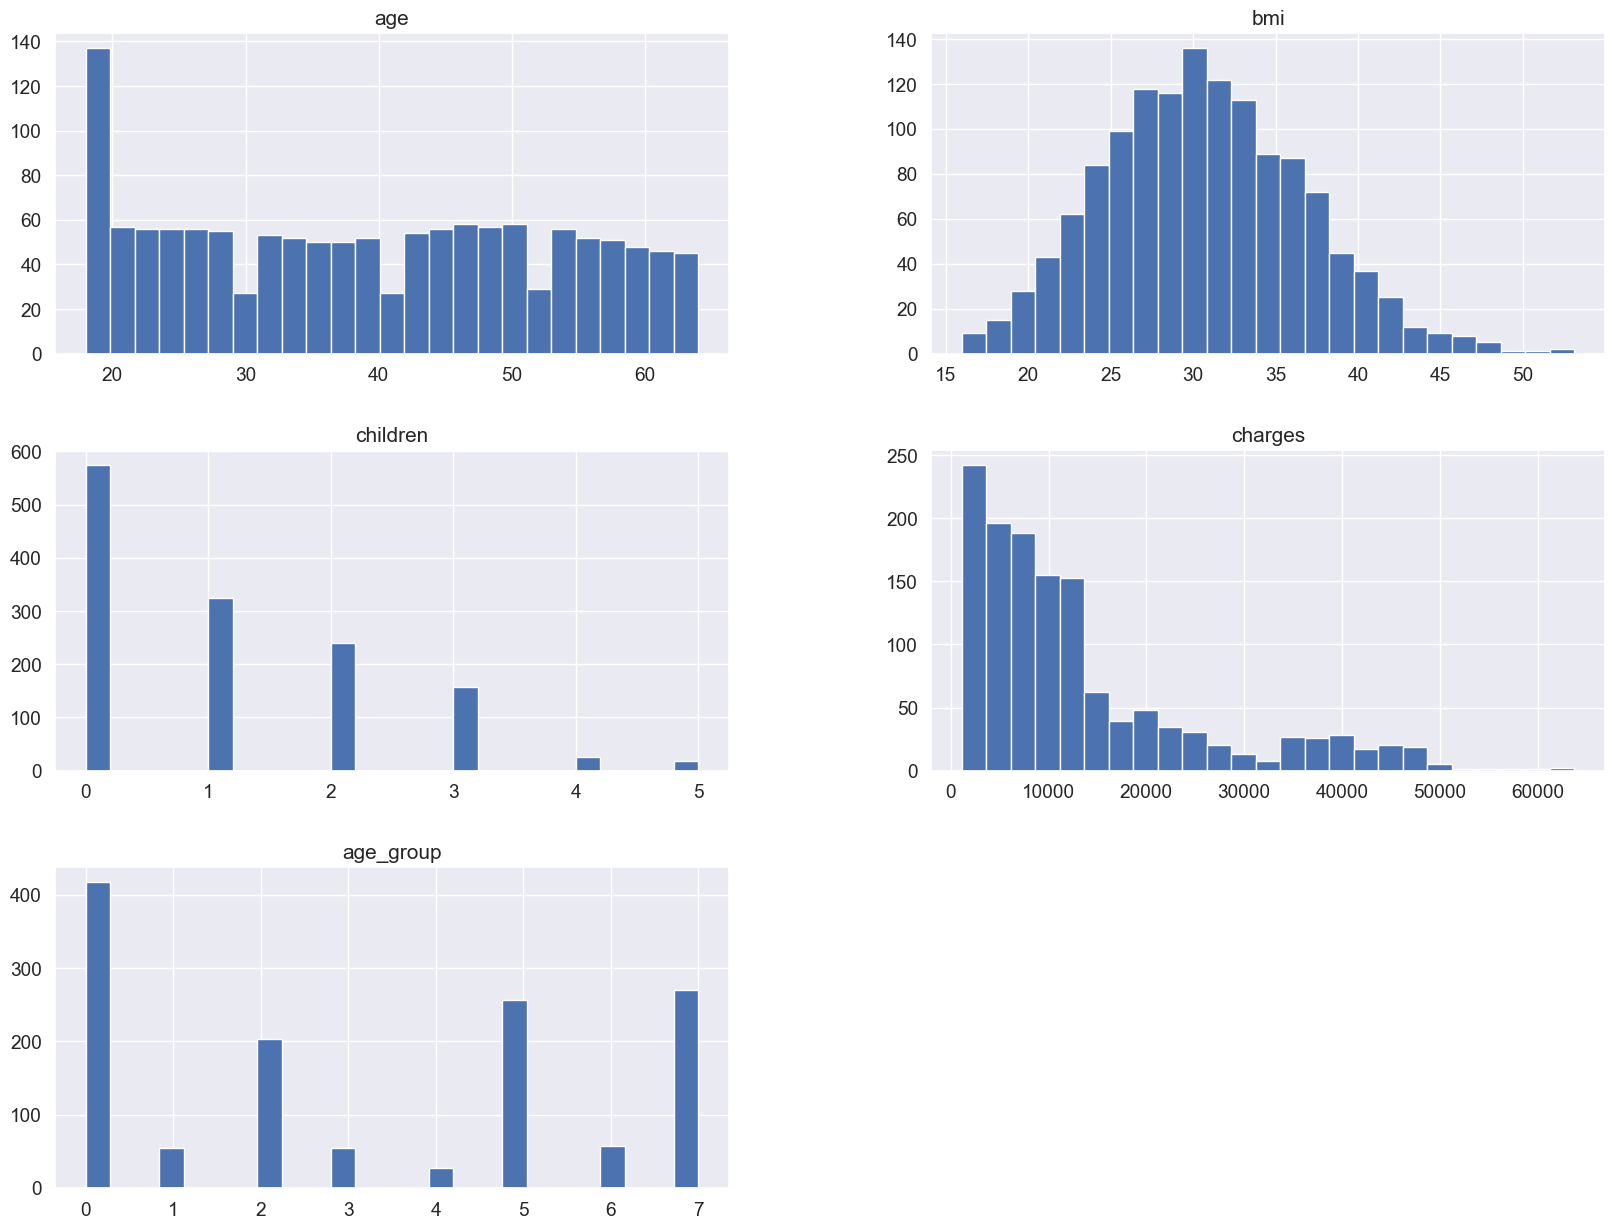

In [1172]:
'''categoria = pd.cut(
    df["age"].astype(int),
    bins=[17,29,31,39,41,42,51,53,64],
    labels=['0', '1', '2','3','4','5','6','7'], 
)
df["age_group"] = categoria.astype(int)
'''
df.hist(bins=25, figsize=(20,15))

plt.show()

#### Creando datos númericos

Cambiamos smoker y sex a un valor binario 1 o 0 

In [1173]:

df.smoker = df.smoker.map({'yes': 1, 'no': 0})
df.sex = df.sex.map({'female': 1, 'male': 0})
# count the smokers and non-smokers
print(df.smoker.value_counts())
print(df.sex.value_counts())


0    1064
1     274
Name: smoker, dtype: int64
0    676
1    662
Name: sex, dtype: int64


Para la columna `region` usaremos el one hot encoding

In [1174]:
encoder = OneHotEncoder(sparse=False)
region_1_hot = encoder.fit_transform(df[['region']])
df=df.join(pd.DataFrame(region_1_hot, columns=[cat for cat in encoder.categories_[0]]))
df.head()


c:\Users\brais.fernandezvazqu\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,sex,bmi,children,smoker,region,charges,age_group,northeast,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,southeast,1725.55230,0,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,southeast,4449.46200,0,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,northwest,21984.47061,2,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,northwest,3866.85520,2,0.0,1.0,0.0,0.0


#### Correlaciones

Con los datos categoricos pasados a numericos podemos observar correlaciones que en un principio no podíamos.

In [1175]:
corrmat = df.corr()

C:\Users\brais.fernandezvazqu\AppData\Local\Temp\ipykernel_6376\2179290573.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


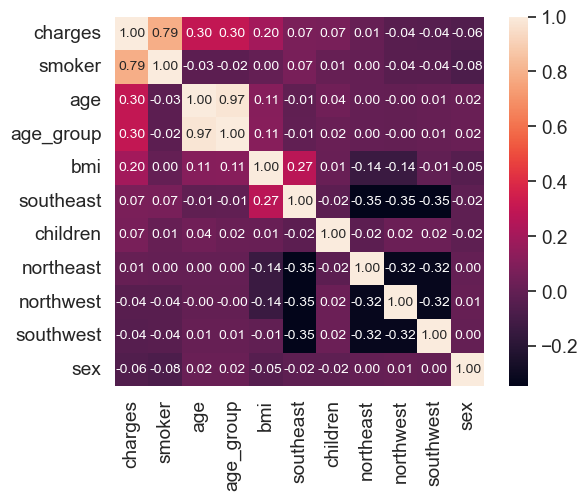

In [1176]:
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Creo que se pueden crear nuevas columnas fusionando smoker con otras a ver si se puede mejorar el modelo.

In [1177]:
df["smoker_fit"] =  df["bmi"].astype(int)*df["smoker"].astype(int)
df["smoker_age"] =  df["smoker"].astype(int)/df["age"].astype(int)
df["southeast_fit"] =  df["southeast"].astype(int)/df["bmi"].astype(int)

C:\Users\brais.fernandezvazqu\AppData\Local\Temp\ipykernel_6376\3618402491.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


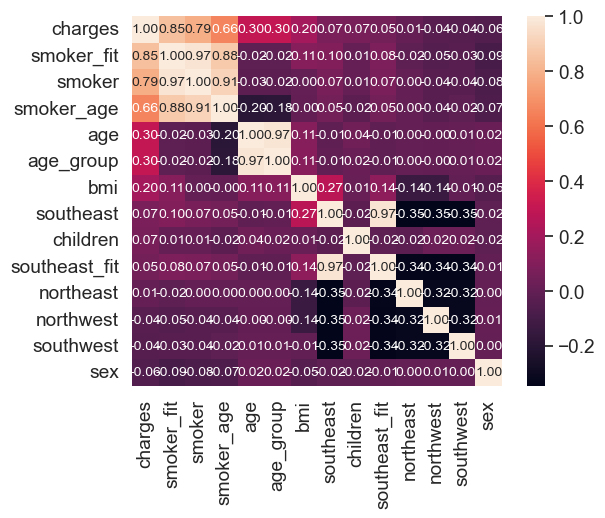

In [1178]:
corrmat = df.corr()
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'bmi'}>,
        <AxesSubplot: title={'center': 'children'}>],
       [<AxesSubplot: title={'center': 'smoker'}>,
        <AxesSubplot: title={'center': 'charges'}>,
        <AxesSubplot: title={'center': 'age_group'}>,
        <AxesSubplot: title={'center': 'northeast'}>],
       [<AxesSubplot: title={'center': 'northwest'}>,
        <AxesSubplot: title={'center': 'southeast'}>,
        <AxesSubplot: title={'center': 'southwest'}>,
        <AxesSubplot: title={'center': 'smoker_fit'}>],
       [<AxesSubplot: title={'center': 'smoker_age'}>,
        <AxesSubplot: title={'center': 'southeast_fit'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

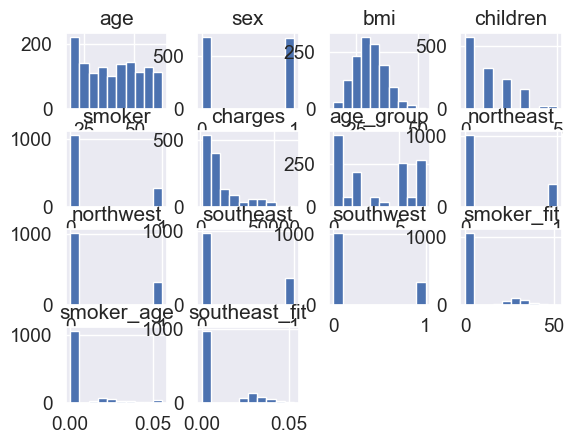

In [1179]:
df.hist()

### Modelos

#### Linear Regression

#### Vector Support Machine

#### Random Forest

#### Gradient Boosting

#### XGBoost